```
Copyright 2019 Augusto Cunha and Axelle Pochet

Permission is hereby granted, free of charge, to any person obtaining a copy of this code and 
associated documentation files, to deal in the code without restriction, 
including without limitation the rights to use, copy, modify, merge, publish, distribute, 
sublicense, and/or sell copies of the code, and to permit persons to whom the code is 
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or 
substantial portions of the code.

THE CODE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT 
NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND 
NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, 
DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, 
OUT OF OR IN CONNECTION WITH THE CODE OR THE USE OR OTHER DEALINGS IN THE CODE.

__license__ = "MIT"
__author__ = "Augusto Cunha, Axelle Pochet"
__email__ = "acunha@tecgraf.puc-rio.br, axelle@tecgraf.puc-rio.br"
__credits__ = ["Augusto Cunha", "Axelle Pochet", "Helio Lopes", "Marcelo Gattass"]
```

# SFD-CNN-TL: Train final model and save

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ['KERAS_BACKEND'] = 'tensorflow'

import sys
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as im
import classifier
import imageio
import keras.utils.vis_utils as graph # new keras version
from mpl_toolkits.axes_grid1 import make_axes_locatable
from skimage.filters import gaussian
from skimage import measure
from skimage import exposure
from sklearn.feature_extraction import image
from sklearn import svm
from sklearn.externals import joblib
from sklearn.utils import shuffle
from matplotlib.colors import LinearSegmentedColormap
from PIL import Image, ImageDraw
from keras.models import Sequential, Model, model_from_json
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D # new keras version
from keras.utils import np_utils
from keras import regularizers
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

np.random.seed(1337)

Using TensorFlow backend.


In [2]:
# Enable interactive plots
%matplotlib notebook

## Workflow
- Use our provided Syntectic dataset network weights
- Interpret one slice of the real data volume that will be classified
- Generate slice fault mask
- Train and save each analyzed method

## Define a seismic name

In [2]:
seismic_name = "gsb"

## Format csv file

In [3]:
# Gaussian smoothing with default std 1.5
# https://stackoverflow.com/a/45020378
def myGaussSmooth( data, std=1.5):
    return gaussian(data,sigma=std,truncate=2)

In [4]:
#Clipping 
def clip(data,min=-6000,max=6000):
    data[data>max] = max
    data[data<min] = min
    return data

In [5]:
# Normalizes values of a matrix between -1 and 1
def myNormalization(data):
    max_val = np.max(data)
    min_val = np.min(data)
    
    return  2 * (data[:,:] - min_val) / (max_val - min_val) - 1

In [18]:
sections = []

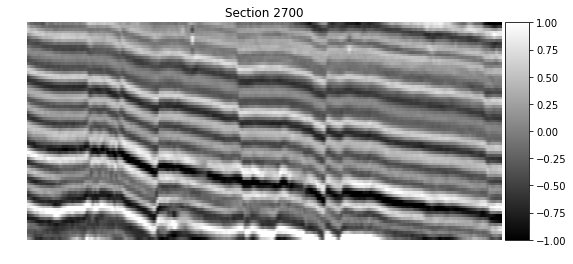

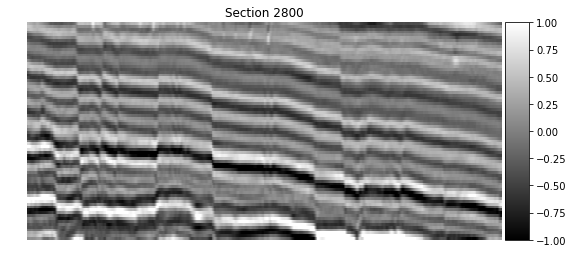

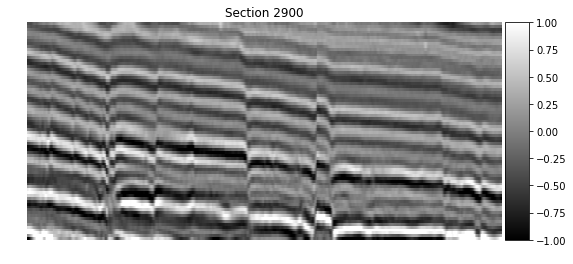

In [19]:
# Load sections
for i in [2700,2800,2900]: #[2700,2800,2900]:
    # Set configurations for format subvolume
    data_file = 'data/gsb_crl_'+str(i)+'.csv'
    min_inl = 1565 #1565
    max_inl = 2531 #2531
    step_inl = 2
    min_crl = i #2568
    max_crl = i #3568
    step_crl = 2
    min_z = 1000
    max_z = 1300
    step_z = 4

    # Define sections type
    types=['inline','crossline','z-slice','section_coords']
    section_type = 'crossline'

    output_dir = 'data/formatted/'+seismic_name+'/'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir) 

    # Read and format files
    raw_data = np.genfromtxt(data_file, delimiter='\t')

    if(section_type == "inline"):
        nb_crosslines = (max_crl - min_crl) / step_crl + 1

    if(section_type == "crossline"):
        nb_crosslines = (max_inl - min_inl) / step_inl + 1

    nb_sections = raw_data.shape[0]/nb_crosslines

    for k in range(int(nb_sections)):
        # Output name
        if(section_type == "inline"):
            inl_nb = int(min_inl + k);
            name = 'inl'+str(inl_nb)+'_sc_formatted.csv'
        if(section_type == "crossline"):
            crl_nb = int(min_crl + k);
            name = 'crl'+str(crl_nb)+'_sc_formatted.csv'

        # Read
        section = raw_data[k*int(nb_crosslines) : (k+1)*int(nb_crosslines), : ]
        section = np.transpose(section)
        section = np.fliplr(section)

        # Smooth
        section = myGaussSmooth(section, std=1.0)

        # Clip
        #section = clip(section)

        perc = np.percentile(section, [1,99])
        section = exposure.rescale_intensity(section, in_range=(perc[0], perc[1]), out_range=(-1,1))

        # Normalize between -1 and 1 
        #section = myNormalization(section)

        # Write
        #np.savetxt(output_dir + name, section, delimiter=" ")

        # Append
        sections.append(section)

        # Visualize
        plt.figure(figsize=(9,4))
        plt.title('Section ' + str(i))
        plt.axis('off')
        ax = plt.gca()
        im = plt.imshow(section, cmap="gray", aspect='auto')

        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)

## Create colormap

In [8]:
# get colormap
ncolors = 256
color_array = plt.get_cmap('gray')(range(ncolors))
# change alpha values
color_array[:,-1] = np.linspace(0.0,1.0,ncolors)
color_array[255] = [1., 0., 0., 0.5]

# create a colormap object
map_object = LinearSegmentedColormap.from_list(name='faults',colors=color_array)

# register this new colormap with matplotlib
plt.register_cmap(cmap=map_object)

## Generate mask image from fault points file
Our faults was exported from opendTect as ordered point set, witch points pair is one fault

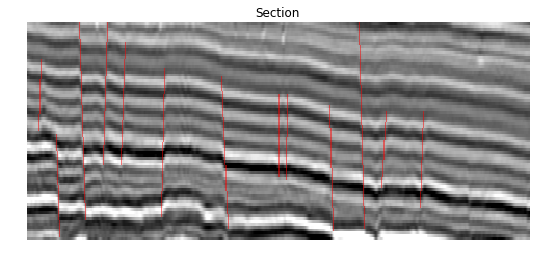

In [20]:
mask_file = 'data/gsb_crl_2800_mask.ascii'
mask_data = np.genfromtxt(mask_file, delimiter='\t')
lines_pair_points = []

for i in range(0,mask_data.shape[0]):
    lines_pair_points.append((mask_data[i,6]-min_inl)/step_inl)
    lines_pair_points.append(int((mask_data[i,2]-min_z)/step_z))

im = Image.new('L', (section.shape[1], section.shape[0]), 0)

draw = ImageDraw.Draw(im)
for i in range(0,len(lines_pair_points),4):
    draw.line((lines_pair_points[i],lines_pair_points[i+1],lines_pair_points[i+2],lines_pair_points[i+3]), fill=1, width=1)
del draw

mask_img = np.array(im)
mask_img = np.fliplr(mask_img)

 # Visualize
plt.figure(figsize=(9,4))
plt.title('Section')
plt.axis('off')
plt.imshow(sections[1], cmap="gray", aspect='auto')
plt.imshow(mask_img, cmap="faults", aspect='auto')
plt.imsave('mask.png', mask_img, cmap="gray")

mask_img_2800 = mask_img

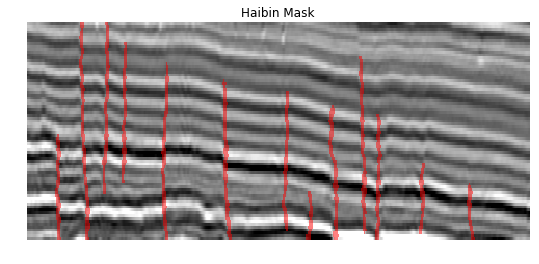

In [21]:
# Load Haibin mask
haibin_mask = cv2.imread("gsb_crl2800_haibin_mask.png")
haibin_mask = haibin_mask[:,:,1]
haibin_mask = haibin_mask/255

mask_img = haibin_mask

plt.figure(figsize=(9,4))
plt.title('Haibin Mask')
plt.axis('off')
plt.imshow(sections[1], cmap="gray", aspect='auto')
plt.imshow(haibin_mask, cmap="faults", aspect='auto')
plt.imsave('mask_haibin.png', haibin_mask, cmap="gray")

mask_img_2800 = mask_img

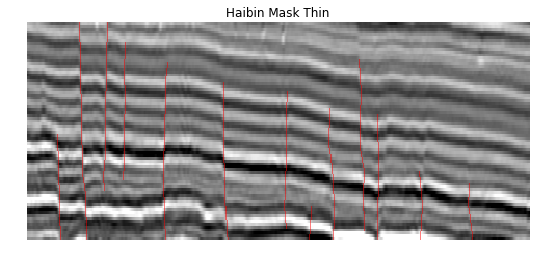

In [22]:
# Load thin Haibin mask
haibin_mask = cv2.imread("gsb_crl2800_haibin_thin_mask.png")
haibin_mask = haibin_mask[:,:,1]
haibin_mask = haibin_mask/255

mask_img = haibin_mask

plt.figure(figsize=(9,4))
plt.title('Haibin Mask Thin')
plt.axis('off')
plt.imshow(sections[1], cmap="gray", aspect='auto')
plt.imshow(haibin_mask, cmap="faults", aspect='auto')
plt.imsave('mask_haibin_thin.png', haibin_mask, cmap="gray")

mask_img_2800 = mask_img

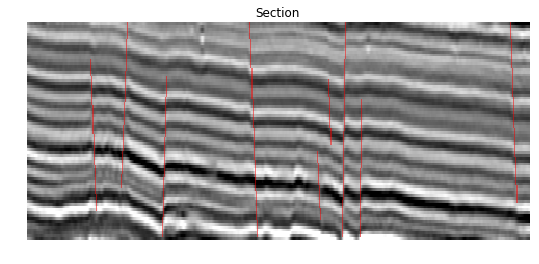

In [23]:
# Load mask for crossline 2700
mask_file = 'data/gsb_crl_2700_mask.ascii'
mask_data = np.genfromtxt(mask_file, delimiter='\t')
lines_pair_points = []

for i in range(0,mask_data.shape[0]):
    lines_pair_points.append((mask_data[i,6]-min_inl)/step_inl)
    lines_pair_points.append(int((mask_data[i,2]-min_z)/step_z))

im = Image.new('L', (section.shape[1], section.shape[0]), 0)

draw = ImageDraw.Draw(im)
for i in range(0,len(lines_pair_points),4):
    draw.line((lines_pair_points[i],lines_pair_points[i+1],lines_pair_points[i+2],lines_pair_points[i+3]), fill=1, width=1)
del draw

mask_img = np.array(im)
mask_img = np.fliplr(mask_img)

 # Visualize
plt.figure(figsize=(9,4))
plt.title('Section')
plt.axis('off')
plt.imshow(sections[0], cmap="gray", aspect='auto')
plt.imshow(mask_img, cmap="faults", aspect='auto')
plt.imsave('mask.png', mask_img, cmap="gray")

mask_img_2700 = mask_img

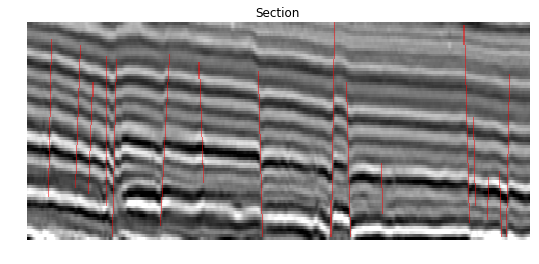

In [24]:
# Load mask for crossline 2900
mask_file = 'data/gsb_crl_2900_mask.ascii'
mask_data = np.genfromtxt(mask_file, delimiter='\t')
lines_pair_points = []

for i in range(0,mask_data.shape[0]):
    lines_pair_points.append((mask_data[i,6]-min_inl)/step_inl)
    lines_pair_points.append(int((mask_data[i,2]-min_z)/step_z))

im = Image.new('L', (section.shape[1], section.shape[0]), 0)

draw = ImageDraw.Draw(im)
for i in range(0,len(lines_pair_points),4):
    draw.line((lines_pair_points[i],lines_pair_points[i+1],lines_pair_points[i+2],lines_pair_points[i+3]), fill=1, width=1)
del draw

mask_img = np.array(im)
mask_img = np.fliplr(mask_img)

 # Visualize
plt.figure(figsize=(9,4))
plt.title('Section')
plt.axis('off')
plt.imshow(sections[2], cmap="gray", aspect='auto')
plt.imshow(mask_img, cmap="faults", aspect='auto')
plt.imsave('mask.png', mask_img, cmap="gray")

mask_img_2900 = mask_img

## Generate patches from real slice

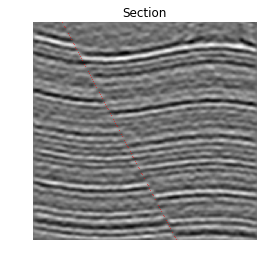

In [25]:
# Our method patch size for Synthetic
mask_size = 45
synthetic_section = np.genfromtxt("SyntheticSection_457.csv", delimiter=' ')
synthetic_section = synthetic_section.T
synthetic_mask = cv2.imread("SyntheticSection_457_mask.png")
synthetic_mask = synthetic_mask[:,:,1]
synthetic_mask = synthetic_mask/255

 # Visualize
plt.figure(figsize=(4,4))
plt.title('Section')
plt.axis('off')
plt.imshow(synthetic_section, cmap="gray", aspect='auto')
plt.imshow(synthetic_mask, cmap="faults", aspect='auto')

synthetic_patches_fault = []
synthetic_patches_non_fault = []

patches_img = image.extract_patches_2d(synthetic_section, (mask_size, mask_size))
patches_mask = image.extract_patches_2d(synthetic_mask, (mask_size, mask_size))

for i in range(0, len(patches_mask)):
    if (patches_mask[i] == 0).sum() == patches_mask[i].size:
        patch = patches_img[i]
        patch = cv2.resize(patch, dsize=(45, 45), interpolation=cv2.INTER_CUBIC)
        patch = np.clip(patch, -1., 1.)
        synthetic_patches_non_fault.append(patch)
    elif patches_mask[i][int(mask_size/2),int(mask_size/2)]==1:
        patch = patches_img[i]
        patch = cv2.resize(patch, dsize=(45, 45), interpolation=cv2.INTER_CUBIC)
        patch = np.clip(patch, -1., 1.)
        synthetic_patches_fault.append(patch)

In [26]:
# Use this cell or next cell to select use our mask size or Haibin mask size
# Our method patch size
mask_size = 13

patches_fault = []
patches_non_fault = []

masks = [mask_img_2700,mask_img_2800,mask_img_2900]

top, bottom, left, right = [int(mask_size/2)]*4

for sec_idx in range(len(sections)):
    #reflected_section = cv2.copyMakeBorder(sections[sec_idx], top, bottom, left, right, cv2.BORDER_REFLECT)
    #reflected_mask = cv2.copyMakeBorder(masks[sec_idx], top, bottom, left, right, cv2.BORDER_REFLECT)
    reflected_section = sections[sec_idx]
    reflected_mask = masks[sec_idx]

    patches_img = image.extract_patches_2d(reflected_section, (mask_size, mask_size))
    patches_mask = image.extract_patches_2d(reflected_mask, (mask_size, mask_size))

    for i in range(0, len(patches_mask)):
        if (patches_mask[i] == 0).sum() == patches_mask[i].size:
            patch = patches_img[i]
            patch = cv2.resize(patch, dsize=(45, 45), interpolation=cv2.INTER_CUBIC)
            patch = np.clip(patch, -1., 1.)
            patches_non_fault.append(patch)
        elif patches_mask[i][int(mask_size/2),int(mask_size/2)]==1:
            patch = patches_img[i]
            patch = cv2.resize(patch, dsize=(45, 45), interpolation=cv2.INTER_CUBIC)
            patch = np.clip(patch, -1., 1.)
            patches_fault.append(patch)

In [18]:
# Haibin method patch size
## Use this one if you will test Haibin CNN
mask_size = 15

patches_fault = []
patches_non_fault = []

masks = [mask_img_2700,mask_img_2800,mask_img_2900]

top, bottom, left, right = [int(mask_size/2)]*4
cp = int(mask_size/2)

for sec_idx in range(len(sections)):
    #reflected_section = cv2.copyMakeBorder(sections[sec_idx], top, bottom, left, right, cv2.BORDER_REFLECT)
    #reflected_mask = cv2.copyMakeBorder(masks[sec_idx], top, bottom, left, right, cv2.BORDER_REFLECT)
    reflected_section = sections[sec_idx]
    reflected_mask = masks[sec_idx]

    patches_img = image.extract_patches_2d(reflected_section, (mask_size, mask_size))
    patches_mask = image.extract_patches_2d(reflected_mask, (mask_size, mask_size))

    for i in range(0, len(patches_mask)):
        if (patches_mask[i] == 0).sum() == patches_mask[i].size:
            patch = patches_img[i]
            patch = cv2.resize(patch, dsize=(32, 32), interpolation=cv2.INTER_CUBIC)
            patch = np.clip(patch, -1., 1.)
            patches_non_fault.append(patch)
        elif (patches_mask[i][cp-3:cp+3,cp-3:cp+3]==0).sum() != 7*7:
            patch = patches_img[i]
            patch = cv2.resize(patch, dsize=(32, 32), interpolation=cv2.INTER_CUBIC)
            patch = np.clip(patch, -1., 1.)
            patches_fault.append(patch)

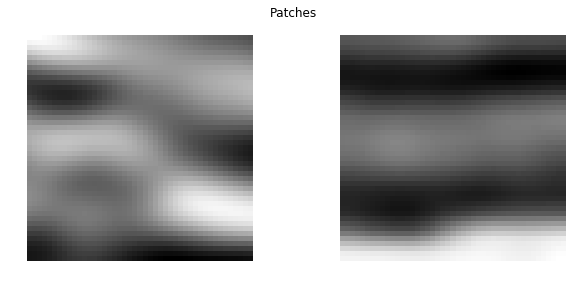

In [27]:
# Compare Synthetic and Real patches

imgs = []
imgs.append(synthetic_patches_fault[60])
imgs.append(patches_fault[60])

fig, axs = plt.subplots(1, 2, figsize=(9, 4))
fig.suptitle('Patches')
axs = axs.flatten()
for img, ax in zip(imgs, axs):
    ax.axis('off')
    ax.imshow(img, cmap="gray")
    
# # Fine-tune figure; hide x ticks for top plots and y ticks for right plots
#plt.setp([a.get_xticklabels() for a in axs[0, :]], visible=False)
#plt.setp([a.get_yticklabels() for a in axs[:, 1]], visible=False)

# Tight layout often produces nice results
# but requires the title to be spaced accordingly
fig.tight_layout()
fig.subplots_adjust(top=0.88, right=0.97)

plt.show(block=True)

## Train and save each analyzed method

In [33]:
print(len(patches_fault))
print(len(patches_non_fault))

520
21895


In [34]:
# pass input as numpy arrays
X = np.array(patches_fault + patches_non_fault)
X = X.reshape( X.shape[0], 45, 45, 1)
#X = X.reshape( X.shape[0], 32, 32, 1) # Use this one if using habin mask size
X = X.astype( 'float32' )

# sparsify labels
patches = np.concatenate([np.full(len(patches_fault),1),np.full(len(patches_non_fault),0)])
Y = np_utils.to_categorical(patches.tolist(), 2)

#Shuffle dataset
shuffle(X, Y, random_state=1337)

[array([[[[ 0.7602754 ],
          [ 0.7608451 ],
          [ 0.7622987 ],
          ...,
          [ 0.6720282 ],
          [ 0.6855265 ],
          [ 0.6896487 ]],
 
         [[ 0.75206697],
          [ 0.7525956 ],
          [ 0.75389904],
          ...,
          [ 0.6801835 ],
          [ 0.69337916],
          [ 0.6974291 ]],
 
         [[ 0.7414539 ],
          [ 0.7418491 ],
          [ 0.74265844],
          ...,
          [ 0.72186923],
          [ 0.73423326],
          [ 0.7380989 ]],
 
         ...,
 
         [[ 0.0074064 ],
          [ 0.00706087],
          [ 0.00585025],
          ...,
          [-0.16321301],
          [-0.16600226],
          [-0.1669199 ]],
 
         [[ 0.08275551],
          [ 0.08246547],
          [ 0.0813363 ],
          ...,
          [-0.10677222],
          [-0.11036943],
          [-0.11153577]],
 
         [[ 0.10380147],
          [ 0.10353249],
          [ 0.1024422 ],
          ...,
          [-0.09277152],
          [-0.09661169],
    

In [35]:
print(X.shape)
print(Y.shape)

(22415, 45, 45, 1)
(22415, 2)


## Haibin CNN
Implementaion of Haibin CNN inspired in his tensorflow code.
Although the architecture and details are the same, the result is very different.

In [46]:
 def create_CNN(x_train, y_train, numberOfClasses=2):
    #### keras Sequential implementation
    model = Sequential([
    Conv2D(16, (9, 9), input_shape=(32,32,1), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    Flatten(),
    Dense(1024, activation='relu'),
    Dense(2, activation='softmax')
    ])

    model.summary()
    #### try just fine tuning base_model
    numberOfEpochs = 300
    batchSize = 30 

    ### Early stopping  
    #early_stop = EarlyStopping(monitor='loss', min_delta=0, patience=3, verbose=1, mode='auto')
    
    model.compile( loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'] )
    #base_model.fit(x_train, y_train, batch_size = batchSize, epochs = numberOfEpochs, verbose = 1, callbacks=[early_stop])
    #model.fit(x_train, y_train, batch_size = batchSize, epochs = numberOfEpochs, verbose = 1)
    datagen = ImageDataGenerator(
        rotation_range=20,
        horizontal_flip=True)

    # compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied)
    datagen.fit(x_train, seed=1337)

    # fits the model on batches with real-time data augmentation:
    model.fit_generator(datagen.flow(x_train, y_train, batch_size=256),
                        steps_per_epoch=(len(x_train) // 256)*6, epochs=numberOfEpochs, verbose = 1)
    
    
    ################# save model #################
    model_json = model.to_json() # base_model
    with open("models/"+seismic_name+"CNN_haibin_3.json", "w") as json_file: json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights("models/"+seismic_name+"CNN_haibin_3.h5") # base_model

In [ ]:
create_CNN(X,Y)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 32, 32, 16)        1312      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 16, 16, 16)        0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 4096)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 1024)              4195328   
_________________________________________________________________
dense_20 (Dense)             (None, 2)                 2050      
Total params: 4,198,690
Trainable params: 4,198,690
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
2046/2046 [==============================] - 86s 42ms/step - loss: 0.5773 - acc: 0.7041
Epoch 2/300
2046/2046 [=========

## VGG

In [36]:
 def create_VGG(x_train, y_train, numberOfClasses=2):
    ################# load base model #################
    modelJsonPath = 'base_model/model.json'
    modelWeightsPath = 'base_model/model.h5'

    jsonFile = open(modelJsonPath, 'r')
    loadedModelJson = jsonFile.read()
    jsonFile.close()
    base_model = model_from_json(loadedModelJson)
    #base_model.load_weights(modelWeightsPath)
        
    #### try just fine tuning base_model
    #numberOfEpochs = 20
    #batchSize = 30 

    ### Early stopping  
    #early_stop = EarlyStopping(monitor='loss', min_delta=0, patience=3, verbose=1, mode='auto')
    
    #base_model.compile( loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'] )
    #base_model.fit(x_train, y_train, batch_size = batchSize, epochs = numberOfEpochs, verbose = 1, callbacks=[early_stop])
    #base_model.fit(x_train, y_train, batch_size = batchSize, epochs = numberOfEpochs, verbose = 1)
        
    ################# save model #################
    model_json = base_model.to_json() # base_model
    with open("models/"+seismic_name+"VGG_haibin_thin.json", "w") as json_file: json_file.write(model_json)
    # serialize weights to HDF5
    base_model.save_weights("models/"+seismic_name+"VGG_haibin_thin.h5") # base_model

In [37]:
create_VGG(X,Y)

## FFT

In [38]:
 def create_FFT(x_train, y_train, numberOfClasses=2):
    ################# load base model #################
    modelJsonPath = 'base_model/model.json'
    modelWeightsPath = 'base_model/model.h5'

    jsonFile = open(modelJsonPath, 'r')
    loadedModelJson = jsonFile.read()
    jsonFile.close()
    base_model = model_from_json(loadedModelJson)
    base_model.load_weights(modelWeightsPath)
        
    #### try just fine tuning base_model
    numberOfEpochs = 20
    batchSize = 30 

    ### Early stopping  
    #early_stop = EarlyStopping(monitor='loss', min_delta=0, patience=3, verbose=1, mode='auto')
    
    base_model.compile( loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'] )
    #base_model.fit(x_train, y_train, batch_size = batchSize, epochs = numberOfEpochs, verbose = 1, callbacks=[early_stop])
    base_model.fit(x_train, y_train, batch_size = batchSize, epochs = numberOfEpochs, verbose = 1, validation_split=0.2)
        
    ################# save model #################
    model_json = base_model.to_json() # base_model
    with open("models/"+seismic_name+"FFT_haibin_thin.json", "w") as json_file: json_file.write(model_json)
    # serialize weights to HDF5
    base_model.save_weights("models/"+seismic_name+"FFT_haibin_thin.h5") # base_model

In [39]:
create_FFT(X,Y)

Train on 17932 samples, validate on 4483 samples
Epoch 1/20
17932/17932 [==============================] - 5s 299us/step - loss: 0.0705 - acc: 0.9868 - val_loss: 0.1467 - val_acc: 0.9806
Epoch 2/20
17932/17932 [==============================] - 4s 231us/step - loss: 0.0412 - acc: 0.9906 - val_loss: 0.1149 - val_acc: 0.9824
Epoch 3/20
17932/17932 [==============================] - 4s 225us/step - loss: 0.0326 - acc: 0.9921 - val_loss: 0.1208 - val_acc: 0.9777
Epoch 4/20
17932/17932 [==============================] - 4s 238us/step - loss: 0.0294 - acc: 0.9920 - val_loss: 0.1677 - val_acc: 0.9721
Epoch 5/20
17932/17932 [==============================] - 4s 229us/step - loss: 0.0232 - acc: 0.9939 - val_loss: 0.1522 - val_acc: 0.9777
Epoch 6/20
17932/17932 [==============================] - 4s 228us/step - loss: 0.0212 - acc: 0.9945 - val_loss: 0.1181 - val_acc: 0.9810
Epoch 7/20
17932/17932 [==============================] - 4s 237us/step - loss: 0.0177 - acc: 0.9950 - val_loss: 0.2370 - v

## MLP

In [40]:
def create_MLP(x, y, numberOfClasses=2, MLP1=100, MLP2=200, numberOfEpochs=20):
    ################# load base model #################
    modelJsonPath = 'base_model/model.json'
    modelWeightsPath = 'base_model/model.h5'

    jsonFile = open(modelJsonPath, 'r')
    loadedModelJson = jsonFile.read()
    jsonFile.close()
    base_model = model_from_json(loadedModelJson)
    base_model.load_weights(modelWeightsPath)

    ## vizualisation
    #base_model.summary()
    
    ################# freeze feature extraction layers #################
    for layer in base_model.layers[:7]:
        layer.trainable = False

    ## vizualisation
    #base_model.summary()

    # remove last layers
    my_model = Sequential(base_model.layers[:-8])

    my_model.summary()

    #### keras Sequential implementation
    model_final = my_model
    model_final.add(Flatten())
    model_final.add(Dense(MLP1)) # 100
    model_final.add(Activation('relu', name = 'act_1')) # set name, otherwise duplicate names appear
    model_final.add(Dropout(0.5)) #0.5 
    model_final.add(Dense(MLP2))
    model_final.add(Activation('relu', name = 'act_2'))
    model_final.add(Dense(numberOfClasses)) # camada de saida
    model_final.add(Activation('softmax', name = 'softmax')) # saida { prob classe1, prob classe2 }
    
    model_final.compile( loss='binary_crossentropy', optimizer= 'sgd', metrics=['accuracy'] )

    ################# train #################

    #### try just fine tuning base_model
    batchSize = 30
    ### Early stopping  
    #early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')
    
    model_final.fit( x, y, batch_size = batchSize, epochs = numberOfEpochs, verbose = 1, validation_split=0.2 )
    
    ################# save model #################
    model_json = model_final.to_json() # base_model
    with open("models/"+seismic_name+"MLP_haibin_thin.json", "w") as json_file: json_file.write(model_json)
    # serialize weights to HDF5
    model_final.save_weights("models/"+seismic_name+"MLP_haibin_thin.h5") # base_model

In [41]:
create_MLP(X,Y)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 43, 43, 20)        200       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 41, 41, 20)        3620      
_________________________________________________________________
activation_1 (Activation)    (None, 41, 41, 20)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 20)        0         
_________________________________________________________________
activation_2 (Activation)    (None, 20, 20, 20)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 18, 18, 50)        9050      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 50)        22550     
__________

## SVM

In [42]:
def create_SVM(data_x, data_y, numberOfClasses=2, c=10, K='rbf', save=False):
    ################# load base model #################
    #print( "Importing base model..." )
    modelJsonPath = 'base_model/model.json'
    modelWeightsPath = 'base_model/model.h5'

    jsonFile = open(modelJsonPath, 'r')
    loadedModelJson = jsonFile.read()
    jsonFile.close()
    base_model = model_from_json(loadedModelJson)
    base_model.load_weights(modelWeightsPath)

    ## vizualisation
    #base_model.summary()

    # remove last layers
    my_model = Sequential(base_model.layers[:-7])

    #my_model.summary()

    ################# freeze feature extraction layers #################
    for layer in my_model.layers[:7]:
        layer.trainable = False

    ## vizualisation
    #base_model.summary()
    ##
    
    ################# format data #################
    # sparsify labels
    numberOfClasses = 2
    y = np.argmax(data_y ,axis=1)
    
    ## extract features as new input
    x = my_model.predict(data_x)
    
    ################# define SVM ################# 
    classifier = svm.SVC(kernel = K, C = c, probability=True, random_state=1337)
    classifier.fit(x, y)
    
    joblib.dump(classifier, 'models/'+seismic_name+'SVM_haibin_thin.pkl')

In [43]:
create_SVM(X,Y)